In [1]:
import pandas as pd
import numpy as np
import sklearn

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

    Index(['aged_writeoff_amt', 'active', 'principal_amt_chrg_off',
           'writeoff_type_null', 'fee_reversals', 'total_writeoff_amt',
           'M_FLBT.IUSA', 'M_FCBC.IUSA', 'bank_fico_buckets_20_<= 560',
           'M_FHST.IUSA', 'M_FIFR_FEDS.IUSA', 'M_FIFR$_FEDS.IUSA',
           'charge_off_aged', 'fc_reversals', 'M_FIP.IUSA'],
          dtype='object')

In [2]:
col_dtypes = {
    "active": np.int8,
    "charge_off": np.int8,
    "charge_off_aged": np.int8,
    "principal_amt_chrg_off": np.float32,
    "total_writeoff_amt": np.float32,
    "aged_writeoff_amt": np.float32,
    "fc_reversals": np.float32,
    "fee_reversals": np.float32,
    "writeoff_type_bko": np.int8,
    "writeoff_type_fraud_kiting": np.int8,
    "writeoff_type_fraud_synthetic": np.int8,
    "writeoff_type_deceased": np.int8,
    "writeoff_type_other": np.int8,
    "writeoff_type_aged": np.int8,
    "writeoff_type_settlement": np.int8,
    "writeoff_type_fraud_other": np.int8,
    "writeoff_type_repo": np.int8,
    "writeoff_type_null": np.int8,
    "month": np.int8,
    "bank_fico_buckets_20_561-580": np.int8,
    "bank_fico_buckets_20_581-600": np.int8,
    "bank_fico_buckets_20_601-620": np.int8,
    "bank_fico_buckets_20_621-640": np.int8,
    "bank_fico_buckets_20_641-660": np.int8,
    "bank_fico_buckets_20_661-680": np.int8,
    "bank_fico_buckets_20_681-700": np.int8,
    "bank_fico_buckets_20_701-720": np.int8,
    "bank_fico_buckets_20_721-740": np.int8,
    "bank_fico_buckets_20_741-760": np.int8,
    "bank_fico_buckets_20_761+": np.int8,
    "bank_fico_buckets_20_<= 560": np.int8,
    "bank_fico_buckets_20_Exception": np.int8,
    "bank_fico_buckets_20_Missing": np.int8, 
    'M_FLBT.IUSA': np.float32,
    'M_FHST.IUSA': np.float32,
    'M_FCBC.IUSA': np.float32,
    'M_FIP.IUSA': np.float32,
    'M_FIFR_FEDS.IUSA': np.float32,
    'M_FIFR$_FEDS.IUSA': np.float32    
}

In [3]:
df = pd.read_csv("training_data_full.csv", dtype=col_dtypes, usecols=list(col_dtypes.keys()))

In [4]:
df.shape

(5758219, 39)

    (5758219, 39)

In [5]:
X = df.drop(["charge_off", "month"], axis=1)
# y = df[["charge_off", "month"]]
y = [(a, b) for a, b in zip(df['charge_off'].astype(bool), df['month'])]
y = np.array(y, dtype=[('charge_off','?'),('month','<f8')])

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.998, random_state=random_state, stratify=df["charge_off"])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=random_state, stratify=y_train["charge_off"])

In [33]:
param_vals_vec = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
train_score_vec = np.zeros(len(param_vals_vec))
test_score_vec = np.zeros(len(param_vals_vec))
# train_rmse_vec = np.zeros(len(param_vals_vec))
# test_rmse_vec = np.zeros(len(param_vals_vec))

for i, param_val in enumerate(param_vals_vec):
    print("Start learning_rate =", param_val)
    gbm_temp = GradientBoostingSurvivalAnalysis(
        n_estimators=500, random_state=42, learning_rate=param_val, verbose=1
    )
    gbm_temp.fit(X_train, y_train)
    train_preds = gbm_temp.predict(X_test)
    train_score_vec[i] = gbm_temp.score(X_train, y_train)
    test_score_vec[i] = gbm_temp.score(X_test, y_test)
    

Start learning_rate = 0.0001
      Iter       Train Loss   Remaining Time 
         1          53.7498           51.29s
         2          53.7490           47.72s
         3          53.7482           48.34s
         4          53.7474           45.11s
         5          53.7466           45.91s
         6          53.7458           44.11s
         7          53.7450           46.48s
         8          53.7442           47.98s
         9          53.7434           47.37s
        10          53.7426           47.46s
        20          53.7347           44.54s
        30          53.7267           44.58s
        40          53.7188           44.83s
        50          53.7108           42.57s
        60          53.7029           42.12s
        70          53.6950           40.63s
        80          53.6870           39.44s
        90          53.6791           38.50s
       100          53.6711           37.79s
       200          53.5917           28.36s
       300          53.51

        10          52.1633           48.53s
        20          50.5801           42.33s
        30          49.0017           42.71s
        40          47.4291           43.82s
        50          45.8636           42.62s
        60          44.3064           42.31s
        70          42.7590           40.60s
        80          41.2233           40.02s
        90          39.7013           38.54s
       100          38.1952           37.24s
       200          24.6199           26.85s
       300          15.3752           18.08s
       400          10.4140            9.29s
       500           7.8398            0.00s
Start learning_rate = 0.05
      Iter       Train Loss   Remaining Time 
         1          53.3534           50.00s
         2          52.9564           42.88s
         3          52.5597           41.12s
         4          52.1632           39.72s
         5          51.7669           41.34s
         6          51.3709           42.61s
         7          50.9752

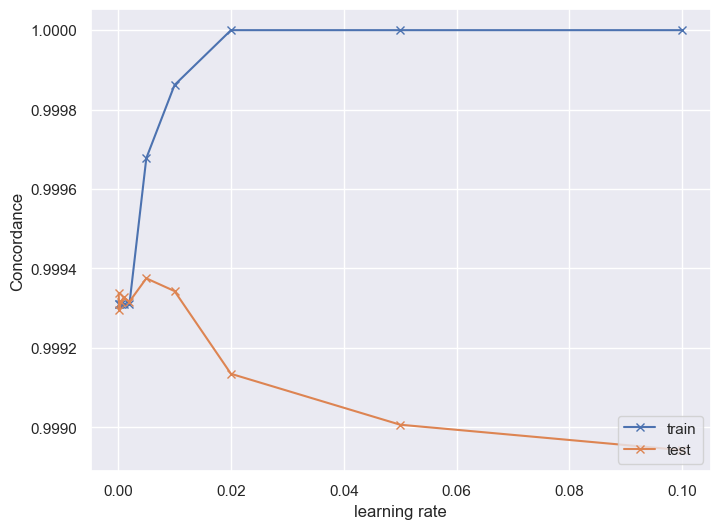

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(param_vals_vec, train_score_vec, marker="x", label="train")
plt.plot(param_vals_vec, test_score_vec, marker="x", label="test")
plt.legend(loc="lower right")
plt.xlabel("learning rate")
plt.ylabel("Concordance")
plt.show()

In [37]:
param_vals_vec = np.arange(1, 10)
train_score_vec = np.zeros(len(param_vals_vec))
test_score_vec = np.zeros(len(param_vals_vec))
# train_rmse_vec = np.zeros(len(param_vals_vec))
# test_rmse_vec = np.zeros(len(param_vals_vec))

for i, param_val in enumerate(param_vals_vec):
    print("Start max_depth =", param_val)
    gbm_temp = GradientBoostingSurvivalAnalysis(
        n_estimators=500, max_depth=param_val, random_state=42, learning_rate=0.01, verbose=1
    )
    gbm_temp.fit(X_train, y_train)
    train_preds = gbm_temp.predict(X_test)
    train_score_vec[i] = gbm_temp.score(X_train, y_train)
    test_score_vec[i] = gbm_temp.score(X_test, y_test)

Start max_depth = 1
      Iter       Train Loss   Remaining Time 
         1          53.6712           52.30s
         2          53.5918            1.09m
         3          53.5125            1.07m
         4          53.4332            1.06m
         5          53.3538            1.10m
         6          53.2745            1.10m
         7          53.1952            1.11m
         8          53.1159            1.12m
         9          53.0366            1.14m
        10          52.9573            1.14m
        20          52.1650            1.04m
        30          51.3737           57.33s
        40          50.5835           58.45s
        50          49.7945           55.72s
        60          49.0069           53.49s
        70          48.2209           52.15s
        80          47.4364           52.25s
        90          46.6538           51.15s
       100          45.8732           50.58s
       200          38.2281           40.49s
       300          31.1238       

        20          52.1630           55.23s
        30          51.3707           58.90s
        40          50.5794            1.00m
        50          49.7894           59.66s
        60          49.0008           59.62s
        70          48.2135           58.62s
        80          47.4279           56.97s
        90          46.6440           55.41s
       100          45.8621           54.24s
       200          38.1925           40.42s
       300          30.9927           27.10s
       400          24.6102           13.68s
       500          19.3485            0.00s
Start max_depth = 9
      Iter       Train Loss   Remaining Time 
         1          53.6711            1.31m
         2          53.5916            1.16m
         3          53.5122            1.19m
         4          53.4328            1.14m
         5          53.3533            1.18m
         6          53.2739            1.20m
         7          53.1945            1.15m
         8          53.1151       

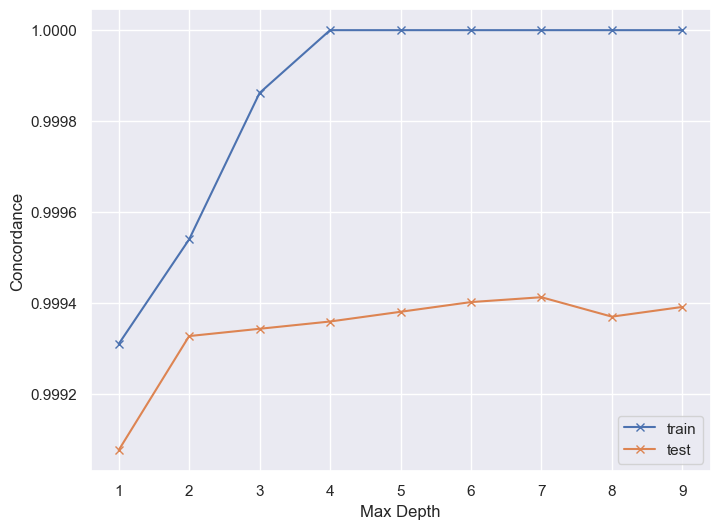

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(param_vals_vec, train_score_vec, marker="x", label="train")
plt.plot(param_vals_vec, test_score_vec, marker="x", label="test")
plt.legend(loc="lower right")
plt.xlabel("Max Depth")
plt.ylabel("Concordance")
plt.show()

## hyperopt

In [7]:
def eval_model(params):
    gbm_temp = GradientBoostingSurvivalAnalysis()
    gbm_temp.set_params(**params, random_state=42, verbose=1)
    gbm_temp.fit(X_train, y_train)
    acc = gbm_temp.score(X_test, y_test)
    return(-acc)

In [8]:
fspace = {
    'learning_rate': hp.loguniform('learning_rate', -10, -1),
    'max_depth': hp.randint('max_depth', 1, 20),
#     'min_samples_leaf': hp.uniform('min_samples_leaf', float(0.00001), float(0.5)),
#     'min_samples_split': hp.loguniform('min_samples_split', -10, -1),
    'n_estimators': hp.randint('n_estimators', 50, 1000)
}

In [9]:
trials = Trials()
best = fmin(fn=eval_model, space=fspace, algo=tpe.suggest, max_evals=100, trials=trials)

      Iter       Train Loss   Remaining Time                                                                           
         1         123.0966            3.10m                                                                           
         2         123.0957            3.08m                                                                           
         3         123.0948            3.06m                                                                           
         4         123.0938            3.05m                                                                           
         5         123.0929            3.05m                                                                           
         6         123.0920            3.03m                                                                           
         7         123.0911            3.02m                                                                           
         8         123.0901            3

        10         122.7116            2.82m                                                                           
        20         122.3256            2.75m                                                                           
        30         121.9398            2.71m                                                                           
        40         121.5539            2.66m                                                                           
        50         121.1682            2.62m                                                                           
        60         120.7825            2.57m                                                                           
        70         120.3969            2.53m                                                                           
        80         120.0114            2.48m                                                                           
        90         119.6259            2

        60         121.0013           28.81s                                                                           
        70         120.6521           26.12s                                                                           
        80         120.3029           23.48s                                                                           
        90         119.9539           20.81s                                                                           
       100         119.6049           18.14s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         122.7513            2.93m                                                                           
         2         122.4052            2.93m                                                                           
         3         122.0590            2

        10         121.1001            3.12m                                                                           
        20         119.1045            3.08m                                                                           
        30         117.1110            3.03m                                                                           
        40         115.1199            2.98m                                                                           
        50         113.1314            2.94m                                                                           
        60         111.1459            2.89m                                                                           
        70         109.1638            2.84m                                                                           
        80         107.1855            2.80m                                                                           
        90         105.2115            2

         2         123.0945            1.51m                                                                           
         3         123.0930            1.50m                                                                           
         4         123.0914            1.50m                                                                           
         5         123.0899            1.50m                                                                           
         6         123.0884            1.50m                                                                           
         7         123.0868            1.49m                                                                           
         8         123.0853            1.49m                                                                           
         9         123.0838            1.48m                                                                           
        10         123.0823            1

        70         122.9193            0.00s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         123.0868           39.53s                                                                           
         2         123.0761           39.86s                                                                           
         3         123.0653           39.80s                                                                           
         4         123.0546           39.61s                                                                           
         5         123.0438           39.32s                                                                           
         6         123.0331           38.87s                                                                           
         7         123.0223           38

       400         115.5649           17.30s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         122.9466            3.73m                                                                           
         2         122.7956            3.73m                                                                           
         3         122.6446            3.74m                                                                           
         4         122.4936            3.73m                                                                           
         5         122.3426            3.74m                                                                           
         6         122.1916            3.74m                                                                           
         7         122.0407            3

         1         123.0933            1.47m                                                                           
         2         123.0891            1.46m                                                                           
         3         123.0848            1.46m                                                                           
         4         123.0806            1.45m                                                                           
         5         123.0764            1.45m                                                                           
         6         123.0721            1.45m                                                                           
         7         123.0679            1.45m                                                                           
         8         123.0636            1.44m                                                                           
         9         123.0594            1

         3         106.5126            1.69m                                                                           
         4         101.0374            1.68m                                                                           
         5          95.6067            1.68m                                                                           
         6          90.2368            1.67m                                                                           
         7          84.9489            1.67m                                                                           
         8          79.7699            1.66m                                                                           
         9          74.7319            1.66m                                                                           
        10          69.8722            1.65m                                                                           
        20          37.0346            1

        10         123.0787            4.32m                                                                           
        20         123.0599            4.30m                                                                           
        30         123.0411            4.26m                                                                           
        40         123.0223            4.22m                                                                           
        50         123.0034            4.17m                                                                           
        60         122.9846            4.11m                                                                           
        70         122.9658            4.05m                                                                           
        80         122.9470            4.00m                                                                           
        90         122.9281            3

        50         122.7792            1.93m                                                                           
        60         122.7155            1.89m                                                                           
        70         122.6519            1.84m                                                                           
        80         122.5882            1.80m                                                                           
        90         122.5245            1.75m                                                                           
       100         122.4609            1.71m                                                                           
       200         121.8244            1.25m                                                                           
       300         121.1881           48.09s                                                                           
       400         120.5519           21

         5         105.0266           32.79s                                                                           
         6         101.4482           32.54s                                                                           
         7          97.8888           32.28s                                                                           
         8          94.3527           32.03s                                                                           
         9          90.8451           31.77s                                                                           
        10          87.3721           31.53s                                                                           
        20          56.5132           28.66s                                                                           
        30          37.8611           25.82s                                                                           
        40          29.1962           23

       100         121.1728            1.45m                                                                           
       200         119.2498           59.49s                                                                           
       300         117.3287           32.01s                                                                           
       400         115.4098            4.64s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         123.0607            1.25m                                                                           
         2         123.0238            1.25m                                                                           
         3         122.9869            1.25m                                                                           
         4         122.9500            1

        40         114.5519            1.82m                                                                           
        50         112.4226            1.77m                                                                           
        60         110.2968            1.73m                                                                           
        70         108.1752            1.68m                                                                           
        80         106.0582            1.64m                                                                           
        90         103.9466            1.60m                                                                           
       100         101.8409            1.55m                                                                           
       200          81.3434            1.12m                                                                           
       300          63.0535           41

        90          25.1212           43.14s                                                                           
       100          23.5481           40.54s                                                                           
       200          17.2394           14.55s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         122.7462            1.28m                                                                           
         2         122.3950            1.27m                                                                           
         3         122.0437            1.26m                                                                           
         4         121.6926            1.26m                                                                           
         5         121.3415            1

        80         120.1971            4.00m                                                                           
        90         119.8348            3.95m                                                                           
       100         119.4725            3.91m                                                                           
       200         115.8543            3.46m                                                                           
       300         112.2445            3.00m                                                                           
       400         108.6452            2.55m                                                                           
       500         105.0589            2.10m                                                                           
       600         101.4887            1.65m                                                                           
       700          97.9383            1

       100         122.8846            2.40m                                                                           
       200         122.6717            1.95m                                                                           
       300         122.4588            1.51m                                                                           
       400         122.2460            1.06m                                                                           
       500         122.0331           37.15s                                                                           
       600         121.8203           10.42s                                                                           
      Iter       Train Loss   Remaining Time                                                                           
         1         123.0900            3.78m                                                                           
         2         123.0825            3

In [10]:
best

{'learning_rate': 5.831241877703163e-05, 'max_depth': 15, 'n_estimators': 665}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

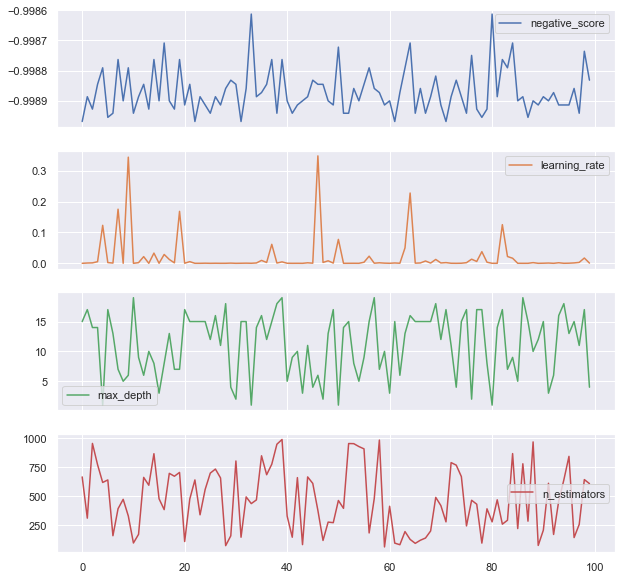

In [12]:
results = np.array([[x['result']['loss'],
                    x['misc']['vals']['learning_rate'][0],
                    x['misc']['vals']['max_depth'][0],
#                     x['misc']['vals']['min_samples_leaf'][0],
                    x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

results_df = pd.DataFrame(results, columns=['negative_score', 'learning_rate', 'max_depth', 'n_estimators'])
results_df.plot(subplots=True, figsize=(10, 10))

In [6]:
best = {'learning_rate': 5.831241877703163e-05, 'max_depth': 15, 'n_estimators': 665}
params = best
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**params, random_state=42, verbose=1)
gbm.fit(X_train, y_train)
acc = gbm.score(X_test, y_test)
acc

      Iter       Train Loss   Remaining Time 
         1         123.0966            4.08m
         2         123.0957            4.12m
         3         123.0948            3.91m
         4         123.0938            4.01m
         5         123.0929            4.22m
         6         123.0920            4.19m
         7         123.0911            4.09m
         8         123.0901            4.03m
         9         123.0892            4.04m
        10         123.0883            4.09m
        20         123.0790            4.03m
        30         123.0697            3.96m
        40         123.0604            4.00m
        50         123.0511            3.95m
        60         123.0418            3.84m
        70         123.0325            3.75m
        80         123.0232            3.63m
        90         123.0139            3.57m
       100         123.0046            3.52m
       200         122.9116            2.97m
       300         122.8186            2.30m
       40

0.9989694121526919

In [12]:
selected_forecast_starting_data = pd.read_csv("selected_forecast_starting_data.csv")

In [13]:
selected_forecast_starting_data = selected_forecast_starting_data[list(X_train.columns)]

In [14]:
predict_survival_function = gbm.predict_survival_function(selected_forecast_starting_data)

In [15]:
def add_prob(i):
    n = len(predict_survival_function)
    sum_prob = 0
    for j in range(n):
        sum_prob = sum_prob + predict_survival_function[j](i)
    return n-int(sum_prob)

In [16]:
charoff_number = {}
for i in range(1,13):
    if i <12:
        charoff_number.update({i+202001:add_prob(i)})
    else:
        charoff_number.update({202101:add_prob(i)})

In [17]:
pred = pd.DataFrame(charoff_number.items(), columns = ["Month", "accounts_charged_off"])

In [18]:
pred

Month  accounts_charged_off
0   202002                    12
1   202003                    16
2   202004                    20
3   202005                    36
4   202006                    36
5   202007                    36
6   202008                    36
7   202009                    43
8   202010                    43
9   202011                    53
10  202012                    76
11  202101                    76

In [19]:
predict_survival_function

array([StepFunction(x=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
              13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]), y=array([1.        , 0.999431  , 0.99922258, 0.99899362, 0.99823338,
              0.99823338, 0.99823338, 0.99823338, 0.99784839, 0.99784839,
              0.99734943, 0.99619594, 0.99619594, 0.99539622, 0.99444879,
              0.99444879, 0.99444879, 0.99444879, 0.99202671, 0.99202671,
              0.98670854, 0.98670854, 0.98670854, 0.98670854]), a=1.0, b=0.0)                                                              ,
       StepFunction(x=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
              13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]), y=array([1.        , 0.999431  , 0.99922258, 0.99899362, 0.99823338,
              0.99823338, 0.99823338, 0.99823338, 0.99784839, 0.99784839,
              0.99734943, 0.99619594, 0.99619594, 0.99539622, 0.99444879,
              0.99444

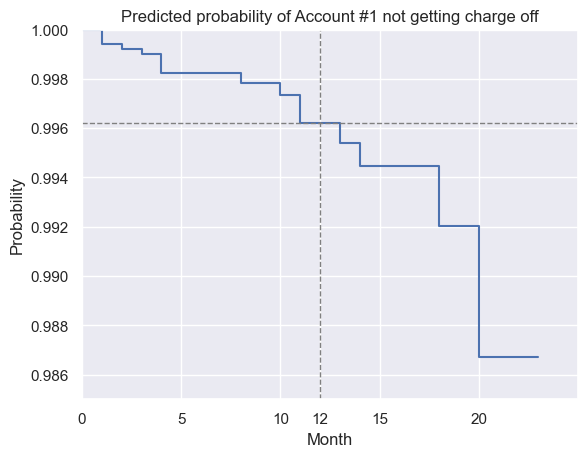

In [39]:
# fig, ax = plt.subplots(1, 1)

for fn in predict_survival_function[:1]:

    plt.step(fn.x, fn(fn.x), where="post")


    
plt.ylim(0.985, 1)
plt.xlim(0, 25)
plt.axvline(12, linestyle="--", label="11", lw=1, color="grey")
plt.axhline(0.99619594, linestyle="--", label="0.99", lw=1, color="grey")

plt.xticks([0, 5, 10, 12, 15, 20])
plt.yticks([0.986, 0.988, 0.990, 0.992, 0.994, 0.996, 0.998, 1.000])
plt.ylabel("Probability")
plt.xlabel("Month")
plt.title("Predicted probability of Account #1 not getting charge off")
plt.show()

In [43]:
chf_funcs = gbm.predict_cumulative_hazard_function(selected_forecast_starting_data)


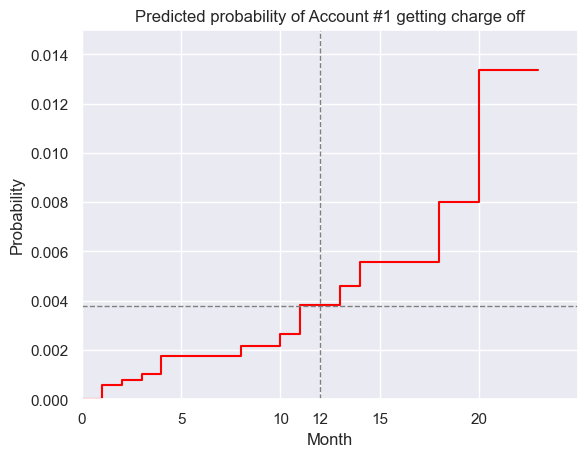

In [47]:

for fn in chf_funcs[:1]:

    plt.step(fn.x, fn(fn.x), where="post", color="red")


plt.ylim(0, 0.015)
plt.xlim(0, 25)
plt.axvline(12, linestyle="--", label="11", lw=1, color="grey")
plt.axhline(1-0.99619594, linestyle="--", label="0.99", lw=1, color="grey")

plt.xticks([0, 5, 10, 12, 15, 20])
plt.yticks([0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014])
plt.ylabel("Probability")
plt.xlabel("Month")
plt.title("Predicted probability of Account #1 getting charge off")
plt.show()

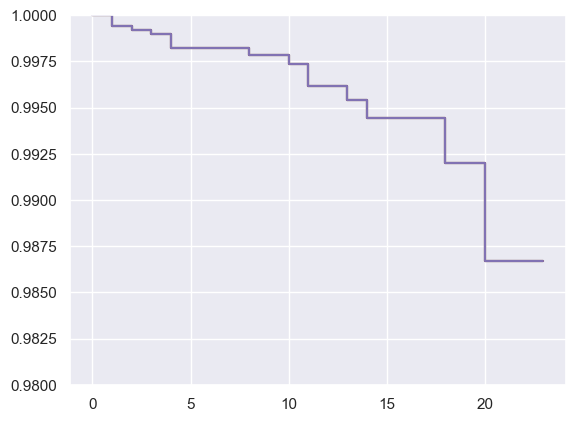

In [10]:
surv_funcs = gbm.predict_survival_function(X_test.iloc[:5])

for fn in surv_funcs:

    plt.step(fn.x, fn(fn.x), where="post")


plt.ylim(0.98, 1)

plt.show()

In [88]:
ft_imp = pd.Series(gbm.feature_importances_, index=X_train.columns).sort_values(ascending=False)
ft_imp[0:20]

writeoff_type_null              0.227485
active                          0.206105
total_writeoff_amt              0.198983
principal_amt_chrg_off          0.184833
writeoff_type_aged              0.181307
M_FIFR_FEDS.IUSA                0.000964
M_FIFR$_FEDS.IUSA               0.000070
M_FIP.IUSA                      0.000036
bank_fico_buckets_20_<= 560     0.000035
bank_fico_buckets_20_761+       0.000025
M_FCBC.IUSA                     0.000023
bank_fico_buckets_20_621-640    0.000021
M_FHST.IUSA                     0.000017
bank_fico_buckets_20_641-660    0.000015
bank_fico_buckets_20_601-620    0.000015
M_FLBT.IUSA                     0.000014
aged_writeoff_amt               0.000012
bank_fico_buckets_20_661-680    0.000012
bank_fico_buckets_20_741-760    0.000006
bank_fico_buckets_20_721-740    0.000005
dtype: float64

In [61]:
import shap

In [62]:
explainer = shap.Explainer(gbm.predict, X_train)

In [63]:
shap_values = explainer(X_test)

Permutation explainer: 5759it [1:12:23,  1.32it/s]                                                                     


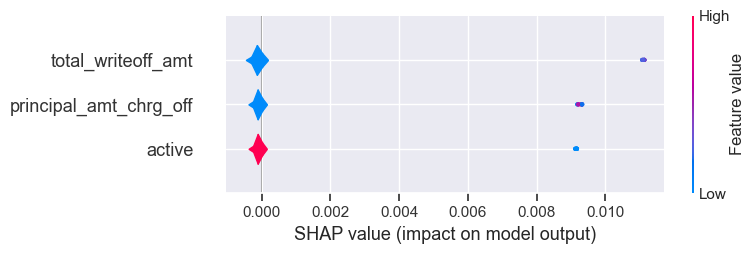

In [71]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = shap.summary_plot(shap_values, X_test, plot_type="violin", max_display=3)
plt.show()

In [ ]:
shap.plots.heatmap(shap_values, max_display=10)

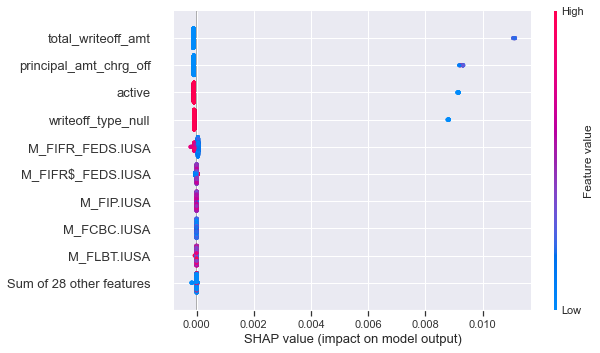

In [33]:
shap.plots.beeswarm(shap_values)

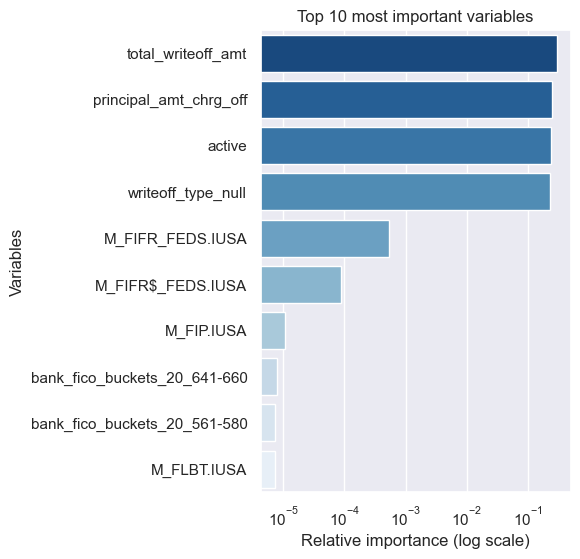

In [60]:
feature_imp = pd.Series(
    gbm.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
ftimp = pd.DataFrame(feature_imp[0:10]).reset_index()
ftimp.columns = ['feature', 'relative_importance']

plt.figure(figsize=(4, 6))
pal = sns.color_palette("Blues", n_colors=len(ftimp))
pal.reverse()
sns.barplot(data=ftimp, x='relative_importance', y='feature', palette=pal)
plt.xscale('log')
plt.xlabel("Relative importance (log scale)")
plt.ylabel("Variables")
plt.title("Top 10 most important variables")
plt.show()

In [50]:
ftimp

feature  relative_importance
0            total_writeoff_amt             0.290021
1        principal_amt_chrg_off             0.240432
2                        active             0.238926
3            writeoff_type_null             0.229912
4              M_FIFR_FEDS.IUSA             0.000536
5             M_FIFR$_FEDS.IUSA             0.000087
6                    M_FIP.IUSA             0.000011
7  bank_fico_buckets_20_641-660             0.000008
8  bank_fico_buckets_20_561-580             0.000007
9                   M_FLBT.IUSA             0.000007